<a href="https://www.kaggle.com/code/muradpitafi/pima-diabetes?scriptVersionId=166351959" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')


In [3]:
def load_dataset(file_path):
    df = pd.read_csv(file_path)
    return df

df = load_dataset("/kaggle/input/pima-indians-diabetes-database/diabetes.csv")

def explore_dataset(df):
    print(df.info())
    print("\nStatistical Summary:")
    print(df.describe())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nClass Distribution:")
    print(df['Outcome'].value_counts())

explore_dataset(df)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Statistical Summary:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458 

In [4]:
def preprocess_data(df):
    x = df.drop('Outcome', axis=1)
    y = df['Outcome']
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
    scaler = StandardScaler()
    xtrain_scaled = scaler.fit_transform(xtrain)
    xtest_scaled = scaler.transform(xtest)
    return xtrain_scaled, xtest_scaled, ytrain, ytest

xtrain, xtest, ytrain, ytest = preprocess_data(df)



In [5]:
def build_model():
    model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', random_state=42)
    return model

model = build_model()



In [6]:
def implement_regularization(model, xtrain, ytrain, regularization='l2', alpha=0.0001):
    if regularization == 'l1':
        model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', alpha=alpha,
                              random_state=42, max_iter=1000)
    elif regularization == 'l2':
        model = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', alpha=alpha,
                              random_state=42, max_iter=1000)
    model.fit(xtrain, ytrain)
    return model

l1_model = implement_regularization(model, xtrain, ytrain, regularization='l1')
l2_model = implement_regularization(model, xtrain, ytrain, regularization='l2')



In [7]:
def tune_hyperparameters(model, xtrain, ytrain):
    param_grid = {
        'hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64)],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.001, 0.01, 0.1]
    }
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(xtrain, ytrain)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    return best_model, best_params

best_model, best_params = tune_hyperparameters(model, xtrain, ytrain)
print("Best Hyperparameters:", best_params)



/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Best Hyperparameters: {'alpha': 0.0001, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.001}


In [8]:
def k_fold_cross_validation(model, x, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracy_scores = []
    x = np.array(x)
    y = np.array(y)
    for train_index, test_index in skf.split(x, y):
        xtrain, xval = x[train_index], x[test_index]
        ytrain, yval = y[train_index], y[test_index]
        model.fit(xtrain, ytrain)
        y_pred = model.predict(xval)
        accuracy = accuracy_score(yval, y_pred)
        accuracy_scores.append(accuracy)
    return np.mean(accuracy_scores)

cv_accuracy = k_fold_cross_validation(best_model, xtrain, ytrain)
print("Cross-validation Accuracy:", cv_accuracy)


Cross-validation Accuracy: 0.7768359322937491


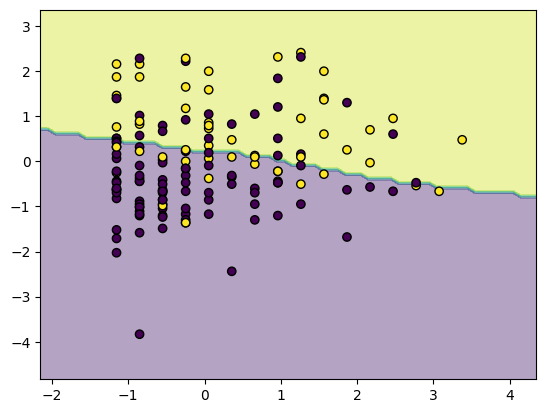

In [9]:
def plot_decision_boundaries(x, y, model):
    # Create a meshgrid of feature values
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel()), np.zeros_like(xx.ravel()),
                            np.zeros_like(xx.ravel()), np.zeros_like(xx.ravel()), np.zeros_like(xx.ravel()),
                            np.zeros_like(xx.ravel())])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(x[:, 0], x[:, 1], c=y, marker='o', edgecolor='k')


plot_decision_boundaries(xtest, ytest, best_model)
plt.show()



In [10]:
def evaluate_model(model, xtest, ytest):
    y_pred = model.predict(xtest)
    accuracy = accuracy_score(ytest, y_pred)
    precision = precision_score(ytest, y_pred)
    recall = recall_score(ytest, y_pred)
    f1 = f1_score(ytest, y_pred)
    print("Model Evaluation:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

evaluate_model(best_model, xtest, ytest)


Model Evaluation:
Accuracy: 0.7142857142857143
Precision: 0.6
Recall: 0.5555555555555556
F1-score: 0.576923076923077


 
### Model Evaluation:
- **Accuracy**: 0.7143
  - The accuracy of the model on the test dataset is approximately 71.43%. This indicates the proportion of correctly classified instances out of all instances in the test set.

- **Precision**: 0.6000
  - The precision of the model on the test dataset is approximately 60.00%. Precision represents the proportion of true positive predictions out of all positive predictions made by the model.

- **Recall**: 0.5556
  - The recall of the model on the test dataset is approximately 55.56%. Recall (also known as sensitivity) represents the proportion of true positive predictions out of all actual positive instances in the dataset.

- **F1-score**: 0.5769
  - The F1-score of the model on the test dataset is approximately 57.69%. F1-score is the harmonic mean of precision and recall and provides a balance between these two metrics.

### Best Hyperparameters:
- **Alpha**: 0.0001
  - Alpha is the L2 regularization parameter. The best value found for alpha during hyperparameter tuning is 0.0001.

- **Hidden Layer Sizes**: (64,)
  - The architecture of the neural network includes one hidden layer with 64 neurons. This architecture was determined to be the best among the options tested during hyperparameter tuning.

- **Learning Rate Init**: 0.001
  - The initial learning rate used by the Adam optimizer during training is 0.001. This parameter controls the step size of the optimization algorithm during training.

### Cross-validation Accuracy:
- **Cross-validation Accuracy**: 0.7768
  - The cross-validation accuracy of the model is approximately 77.68%. This value represents the average accuracy of the model across different folds during k-fold cross-validation. It provides an estimate of the model's performance and generalization ability on unseen data.